# Importing configurations and modules

In [56]:
import numpy as np
import pandas as pd
import tf_keras as keras
import tensorflow as tf
import tensorflow_hub as hub

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB 
from sklearn.feature_extraction.text import TfidfVectorizer

from tf_keras.layers import TextVectorization,Embedding,Dense,Conv1D,GlobalAveragePooling1D
from tf_keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
import tensorflow as tf
from tf_keras.optimizers import Adam

In [57]:
from config.config import *
from callbacks.callbacks import *
from evaluation import get_cm_and_final_results

In [58]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 4050 Laptop GPU (UUID: GPU-3c98d5c3-b19e-acfa-02d3-5c9d5dfaedd2)


# Data processing and understanding

In [59]:
DATA_DIR = DATASET_DIR.joinpath('pubmed-rct')

In [60]:
os.listdir(DATA_DIR)

['PubMed_200k_RCT',
 'PubMed_20k_RCT',
 'PubMed_200k_RCT_numbers_replaced_with_at_sign',
 'PubMed_20k_RCT_numbers_replaced_with_at_sign']

In [61]:
DATASET = 'PubMed_20k_RCT_numbers_replaced_with_at_sign'
DATA_FILES = [DATA_DIR.joinpath(DATASET).joinpath(x) for x in os.listdir(DATA_DIR.joinpath(DATASET))]

In [62]:
DATA_FILES

[PosixPath('/home/yehand/.vscode-server/projects/NLP_Learning/JSCReplication/datasets/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt'),
 PosixPath('/home/yehand/.vscode-server/projects/NLP_Learning/JSCReplication/datasets/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt'),
 PosixPath('/home/yehand/.vscode-server/projects/NLP_Learning/JSCReplication/datasets/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt')]

In [63]:
data = dict()
for path in DATA_FILES:
    with open(path) as file:
        data[file.name.split('/')[-1].split('.')[0]] = file.readlines()

In [64]:
data.keys()

dict_keys(['test', 'train', 'dev'])

In [65]:
start = 0
amount = 20
for key in data:
    print('--------------------------------------------------------------------------------------------------\nData from Dataset', key)
    print(np.array(data[key][start: start+amount]))

--------------------------------------------------------------------------------------------------
Data from Dataset test
['###24845963\n'
 'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n'
 'RESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\n'
 'RESULTS\tLiver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .\n'
 'RESULTS\tSurvival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .\n'
 "RESULTS\tT

## To be more computer friendlty let's preprocess using a function

In [66]:
def process_data(file_name : str) -> list:
    """
    Process a structured text file containing abstracts and convert it into a list of dictionaries.

    Parameters:
        file_name: str
            Path to the input file.
            Expected file format:
            - Abstract headers marked with '###' followed by ID
            - Each line contains tab-separated target and text
            - Abstracts separated by blank lines

    Returns:
        List[Dict[str, Union[str, int]]]: A list of dictionaries, where each dictionary contains:
            - target (str): The target label from the input
            - text (str): The lowercase text content
            - line_number (int): Line position within the abstract (0-based)
            - total_lines (int): Total number of lines in the abstract
            - abstract_id (int): ID extracted from the abstract header

    Raises:
        FileNotFoundError: If the specified file does not exist
        IOError: If there are issues reading the file
        ValueError: If:
            - Abstract ID cannot be converted to integer
            - Line doesn't contain enough tab-separated fields
            - Malformed header line (missing '###' or ID)
        IndexError: If trying to access parts of malformed lines
        TypeError: If file_name is not a string

    Example:
        >>> data = process_data('abstracts.txt')
        >>> print(data[0])
        {
            'target': 'BACKGROUND',
            'text': 'example text here',
            'line_number': 0,
            'total_lines': 5,
            'abstract_id': 1234
        }

    Notes:
        - Text is automatically converted to lowercase for processing efficiency
        - Abstract headers must start with '###' followed by ID
        - Each abstract must end with a blank line
        - Lines must contain at least two tab-separated fields
    """
    data = list()
    with open(file_name) as file:
        data_lines = file.readlines()
    for line in data_lines:
        if line[:3] == '###':
            line_number = 0
            id = line[4:-2]
            abstract = []
            continue
        elif line == '\n':
            for item in abstract:
                item['total_lines'] = line_number
                data.append(item)
        else:
            target, text = line.split('\t')[:2]
            abstract.append(
                {
                    'target' : target,
                    'text' : text.lower().strip('\n'), #lowercase for efficiency
                    'line_number' : line_number,
                    'total_lines' : 0,
                    'abstract_id' : int(id)
                    }
            )
        line_number+=1
    return data

In [67]:
%%time

test = process_data(DATA_FILES[0])
train = process_data(DATA_FILES[1])
val = process_data(DATA_FILES[2])

len(test) ,len(train), len(val)

CPU times: user 1.53 s, sys: 120 ms, total: 1.65 s
Wall time: 1.65 s


(30135, 180040, 30212)

In [68]:
test = process_data(DATA_FILES[0])
train = process_data(DATA_FILES[1])
val = process_data(DATA_FILES[2])
train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)
val_df = pd.DataFrame(val)

## Visualizing the processed data

In [69]:
train_df.head(20)

,target,text,line_number,total_lines,abstract_id
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,12,429357
1,METHODS,a total of @ patients with primary knee oa wer...,1,12,429357
2,METHODS,outcome measures included pain reduction and i...,2,12,429357
3,METHODS,pain was assessed using the visual analog pain...,3,12,429357
4,METHODS,secondary outcome measures included the wester...,4,12,429357
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,12,429357
6,RESULTS,there was a clinically relevant reduction in t...,6,12,429357
7,RESULTS,the mean difference between treatment arms ( @...,7,12,429357
8,RESULTS,"further , there was a clinically relevant redu...",8,12,429357
9,RESULTS,these differences remained significant at @ we...,9,12,429357


In [70]:
NUM_CLASSES = train_df['target'].nunique()
train_df['target'].value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

In [71]:
def word_count(text : str):
    return len([x for x in text.split()])

word_counts = train_df['text'].apply(word_count)

<Axes: ylabel='Frequency'>

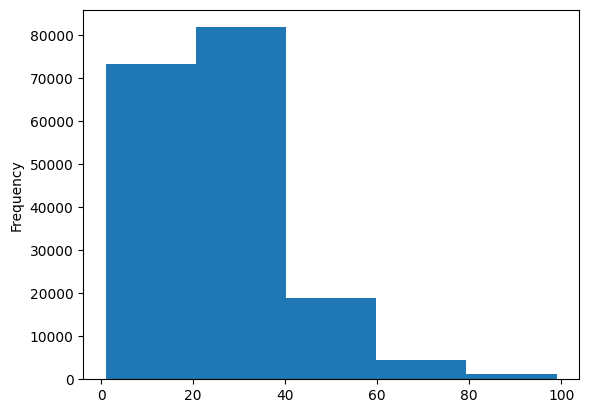

In [72]:
word_counts[word_counts < 100].plot.hist(bins = 5)

<Axes: ylabel='Frequency'>

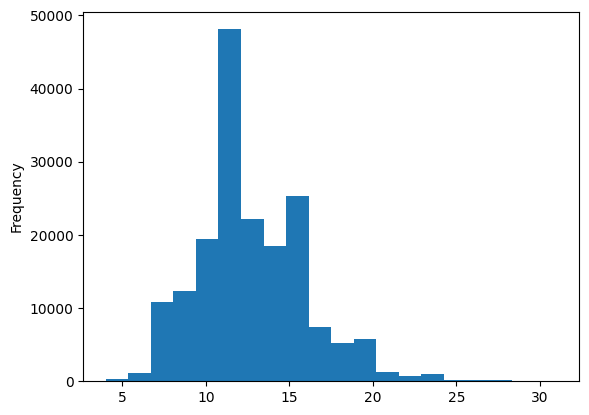

In [73]:
train_df.total_lines.plot.hist(bins = 20)

In [74]:
X_train = train_df['text'].to_numpy()
X_test = test_df['text'].to_numpy()
X_val = val_df['text'].to_numpy()

## Converting labels to numerical format

### One Hot

In [75]:
# Same results using sklearn
one_hot = OneHotEncoder(sparse_output=False)
train_one_hot = one_hot.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
test_one_hot = one_hot.transform(test_df['target'].to_numpy().reshape(-1,1))
val_one_hot = one_hot.transform(val_df['target'].to_numpy().reshape(-1,1))

In [76]:
train_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label Encoding

In [77]:
label_encoder = LabelEncoder()
train_label = label_encoder.fit_transform(train_df['target'].to_numpy())
test_label = label_encoder.transform(test_df['target'].to_numpy())
val_label = label_encoder.transform(val_df['target'].to_numpy())

In [78]:
train_label

array([3, 2, 2, ..., 4, 1, 1])

In [79]:
CLASS_NAMES  = label_encoder.classes_

In [80]:
CLASS_NAMES

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

# Creating Model Baseline

In [81]:
model_0 = Pipeline(
    steps=[
        ('vectorizer', TfidfVectorizer()),
        ( 'clf', MultinomialNB())
    ]
)

In [82]:
model_0.fit(X_train, train_label)

Pipeline(steps=[('vectorizer', TfidfVectorizer()), ('clf', MultinomialNB())])

In [83]:
baseline_preds = model_0.predict(X_val)

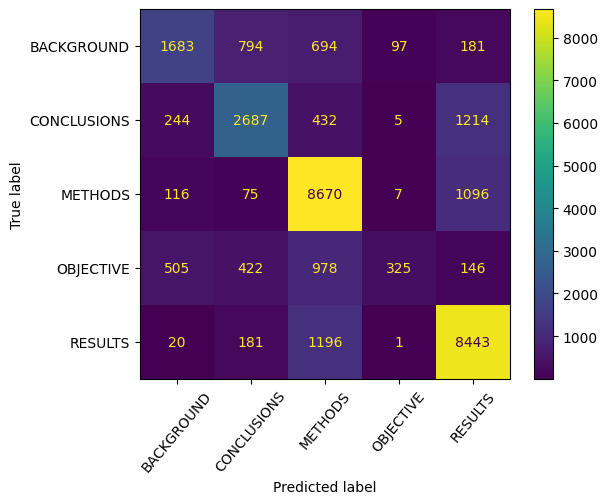

In [84]:
baseline_cm, baseline_report, baseline_metrics = get_cm_and_final_results(baseline_preds, val_label)

In [85]:
baseline_report

,BACKGROUND,CONCLUSIONS,METHODS,OBJECTIVE,RESULTS,accuracy,macro avg,weighted avg
precision,0.655374,0.646069,0.724311,0.747126,0.762004,0.721832,0.706977,0.718647
recall,0.487968,0.586425,0.870132,0.136785,0.857941,0.721832,0.587850,0.721832
f1-score,0.559415,0.614804,0.790553,0.231234,0.807132,0.721832,0.600628,0.698925
support,3449.000000,4582.000000,9964.000000,2376.000000,9841.000000,0.721832,30212.000000,30212.000000


In [86]:
baseline_metrics

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

# Model Version 1 - Simple CNN based

In [87]:
np.percentile(word_counts, 95)

55.0

In [88]:
VOCAB_SIZE = 68000
NUM_TOKENS = 55
vectorizer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_sequence_length=NUM_TOKENS,
)

In [89]:
vectorizer.adapt(X_train)

In [90]:
len(vectorizer.get_vocabulary())

64841

In [91]:
sent = np.random.choice(X_train)

print(sent)

print(vectorizer(sent))

in pre-specified subgroup analyses , the hazard ratios for the primary outcome were compared among centers divided by tertiles and among individual operators .
tf.Tensor(
[   5 1549  853  291    2  426 1124   11    2   56   86    9   34  116
  897  471   22 5165    3  116  565 5491    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0], shape=(55,), dtype=int64)


In [92]:
EMBEDDING_DIMENSIONS = 128
model_1_embedding = Embedding(
    input_dim=len(vectorizer.get_vocabulary()),
    output_dim=EMBEDDING_DIMENSIONS,
    mask_zero=True,
)

In [93]:
EMBEDDING_DIMENSIONS = 128
model_1_embedding = Embedding(
    input_dim=len(vectorizer.get_vocabulary()),
    output_dim=EMBEDDING_DIMENSIONS,
    mask_zero=True,
)

inputs = keras.layers.Input(shape=(1,), dtype=tf.string)

x = vectorizer(inputs)
x = model_1_embedding(x)
x = keras.layers.Conv1D(128,7, activation='relu')(x)
x = keras.layers.MaxPool1D(2)(x)
x = keras.layers.Conv1D(64,3,activation='relu')(x)
x = keras.layers.MaxPool1D(2)(x)
x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dense(64, activation='relu')(x)
outputs = keras.layers.Dense(NUM_CLASSES,activation = 'softmax')(x)

model_1 = keras.Model(inputs,outputs)

model_1.compile(
    optimizer= keras.optimizers.Adam(), 
    loss = CategoricalCrossentropy(), 
    metrics=['accuracy']#, keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()]
    )

In [94]:
model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 55)                0         
 Vectorization)                                                  
                                                                 
 embedding_4 (Embedding)     (None, 55, 128)           8299648   
                                                                 
 conv1d_4 (Conv1D)           (None, 49, 128)           114816    
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 24, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 22, 64)            2464

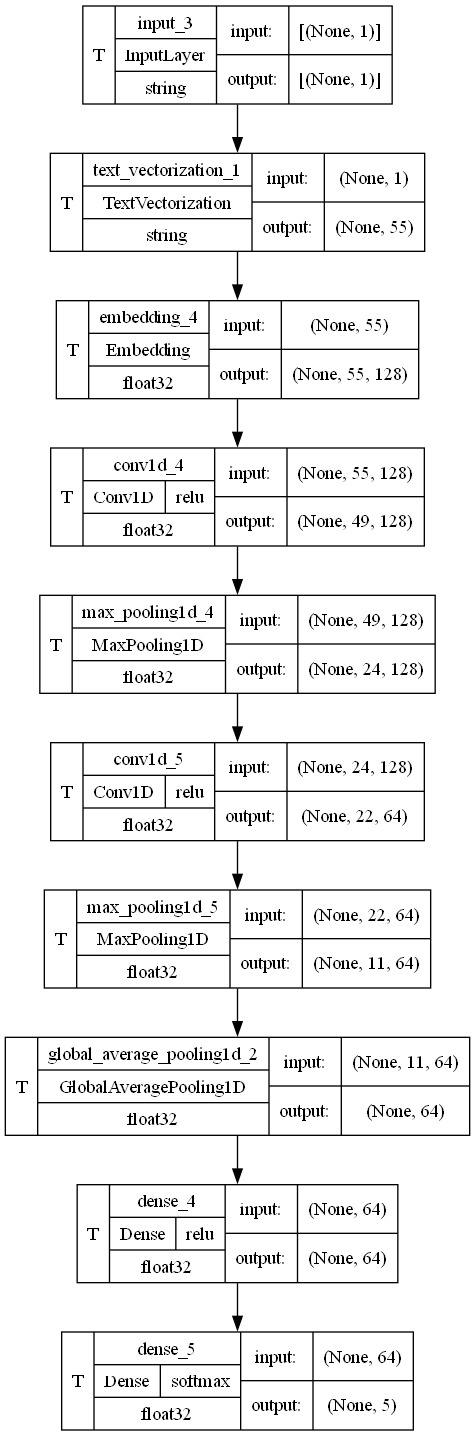

In [95]:
keras.utils.plot_model(
    model=model_1, 
    show_dtype=True,
    show_layer_activations=True,
    expand_nested=True,
    show_shapes=True,
    show_trainable=True
                       )

In [96]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [97]:
len(X_train)/320

562.625

In [98]:
RUN1 = False # Change this to True to run this experiment as see the time difference

In [99]:
if RUN1:
    history_model_1 = model_1.fit(
        X_train,
        train_one_hot,
        validation_data = (X_val, val_one_hot),
        epochs=3,
        initial_epoch=0,
        callbacks=[create_tensorboard_callback('CNN', 'RUN1')],
        steps_per_epoch = 560,
        validation_steps = 560,
        batch_size=BATCH_SIZE
    )

In [100]:
if RUN1:
    model_1_preds = np.argmax(model_1.predict(X_val),axis=-1)
    model_1_preds, val_label

In [101]:
if RUN1:
    model_1_cm, model_1_report, model_1_metrics = get_cm_and_final_results(model_1_preds, val_label)

In [102]:
if RUN1:
    model_1_report

## Processing data to tf Datasets to make faster calculations

In [103]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    tensors=(X_train, train_one_hot)
    ).batch(
            batch_size=BATCH_SIZE,num_parallel_calls=tf.data.AUTOTUNE
            ).cache().prefetch(
                buffer_size=tf.data.AUTOTUNE
                )
test_dataset = tf.data.Dataset.from_tensor_slices(
    tensors=(X_test, test_one_hot)
    ).batch(
            batch_size=BATCH_SIZE,num_parallel_calls=tf.data.AUTOTUNE
            ).cache().prefetch(
                buffer_size=tf.data.AUTOTUNE
                )
val_dataset = tf.data.Dataset.from_tensor_slices(
    tensors=(X_val, val_one_hot)
    ).batch(
            batch_size=BATCH_SIZE,num_parallel_calls=tf.data.AUTOTUNE
            ).cache().prefetch(
                buffer_size=tf.data.AUTOTUNE
                )


In [104]:
for line,label in train_dataset.take(1):
    print(np.concatenate((np.expand_dims(line.numpy(), axis=-1), label.numpy()),axis=-1)[:5])

[[b'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .'
  0.0 0.0 0.0 1.0 0.0]
 [b'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .'
  0.0 0.0 1.0 0.0 0.0]
 [b'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .'
  0.0 0.0 1.0 0.0 0.0]
 [b'pain was assessed using the visual analog pain scale ( @-@ mm ) .'
  0.0 0.0 1.0 0.0 0.0]
 [b'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .'
  0.0 0.0 1.0 0.0 0.0]]


2024-11-23 17:30:51.721066: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-11-23 17:30:51.722333: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Updating model to fit in with new procedure

In [105]:
#Enabling mixed float
keras.mixed_precision.set_global_policy('mixed_float16')

In [106]:
EMBEDDING_DIMENSIONS = 128
model_1_embedding = Embedding(
    input_dim=len(vectorizer.get_vocabulary()),
    output_dim=EMBEDDING_DIMENSIONS,
    mask_zero=True,
)

inputs = keras.layers.Input(shape=(1,), dtype=tf.string)

x = vectorizer(inputs)
x = model_1_embedding(x)
x = keras.layers.Conv1D(128,7, activation='relu')(x)
x = keras.layers.MaxPool1D(2)(x)
x = keras.layers.Conv1D(64,3,activation='relu')(x)
x = keras.layers.MaxPool1D(2)(x)
x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dense(NUM_CLASSES)(x)
outputs = keras.layers.Activation(keras.activations.softmax, dtype=tf.float32)(x)

model_1 = keras.Model(inputs,outputs)

model_1.compile(
    optimizer= keras.optimizers.Adam(), 
    loss = CategoricalCrossentropy(), 
    metrics=['accuracy']#, keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()]
    )

In [107]:
def plot_model(model):
    return keras.utils.plot_model(
    model=model, 
    show_dtype=True,
    show_layer_activations=True,
    expand_nested=True,
    show_shapes=True,
    show_trainable=True
                       )

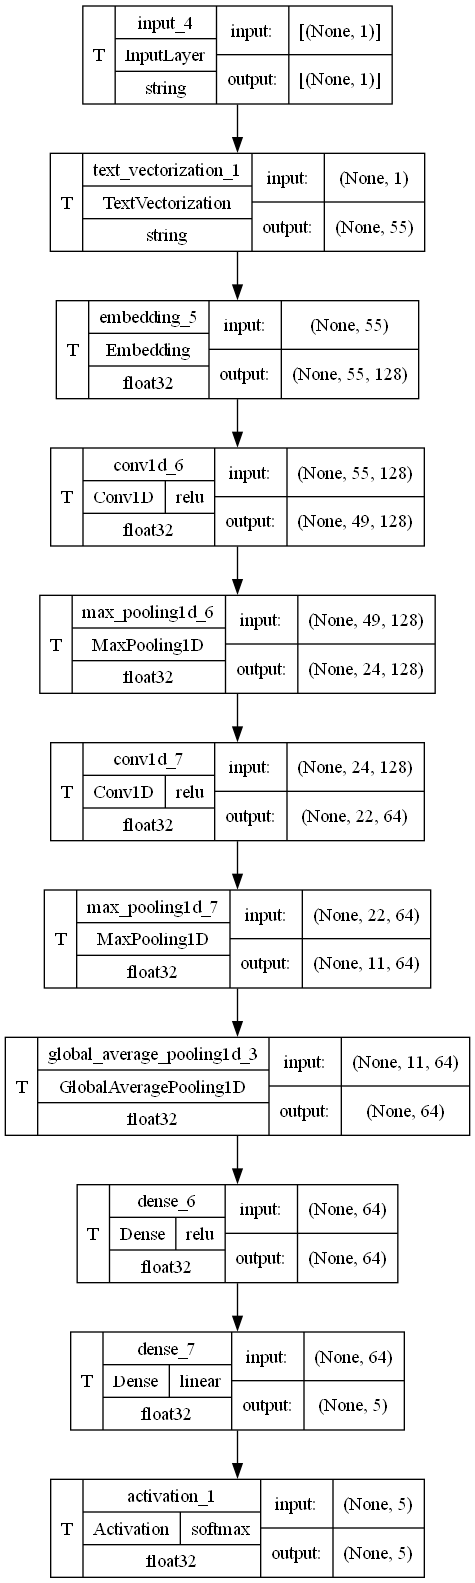

In [108]:
keras.utils.plot_model(
    model=model_1, 
    show_dtype=True,
    show_layer_activations=True,
    expand_nested=True,
    show_shapes=True,
    show_trainable=True
                       )

In [109]:
model_1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 55)                0         
 Vectorization)                                                  
                                                                 
 embedding_5 (Embedding)     (None, 55, 128)           8299648   
                                                                 
 conv1d_6 (Conv1D)           (None, 49, 128)           114816    
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 24, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 22, 64)            2464

In [110]:
history_model_1 = model_1.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs=3,
    initial_epoch=0,
    batch_size=BATCH_SIZE,
    callbacks=[create_tensorboard_callback('CNN', 'RUN2')],
    steps_per_epoch = int(len(train_dataset)/10),
    validation_steps = int(len(val_dataset)/10)
)

Saving log files to : /home/yehand/.vscode-server/projects/NLP_Learning/JSCReplication/experiments/CNN/RUN2
Epoch 1/3
562/562 [==============================] - 62s 106ms/step - loss: 0.9131 - accuracy: 0.6226 - val_loss: 0.6950 - val_accuracy: 0.7287
Epoch 2/3
  2/562 [..............................] - ETA: 39s - loss: 0.9021 - accuracy: 0.6719

2024-11-23 17:31:56.034855: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


562/562 [==============================] - 37s 66ms/step - loss: 0.6625 - accuracy: 0.7443 - val_loss: 0.6250 - val_accuracy: 0.7656
Epoch 3/3


2024-11-23 17:32:33.294675: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


562/562 [==============================] - 43s 76ms/step - loss: 0.6160 - accuracy: 0.7658 - val_loss: 0.5774 - val_accuracy: 0.7846


2024-11-23 17:33:16.256258: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-11-23 17:33:16.317042: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [111]:
model_1_preds = np.argmax(model_1.predict(val_dataset), axis=-1)

945/945 [==============================] - 11s 11ms/step


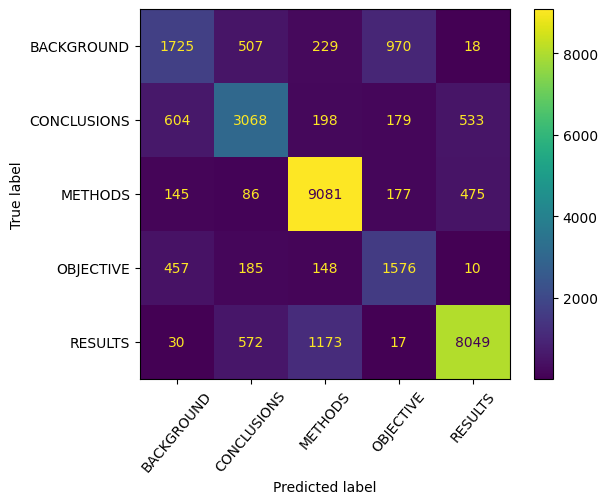

In [112]:
model_1_cm, model_1_report, model_1_metrics = get_cm_and_final_results(model_1_preds, val_label)

# Model Version 2 - Pretrained Embeddings

In [113]:
universal_sentence_encoder = hub.KerasLayer(
    handle="https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2",
    trainable=False,
    name='USE'
)

In [114]:
universal_sentence_encoder([' what joja', 'n'])

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[-0.04555983, -0.00660281, -0.01276617, ..., -0.04721962,
         0.07622743,  0.01372085],
       [-0.02442588, -0.03740193, -0.01249437, ..., -0.07511895,
         0.04019829,  0.00873134]], dtype=float32)>

In [115]:
class USE(keras.layers.Layer):

    def __init__(self, encoder):

        super().__init__()
        self.encoder = encoder
    
    def call(self, inputs):
        return self.encoder(inputs)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "encoder": self.encoder,
        })

        return config

In [116]:
# model_2 = keras.Sequential([
#     keras.layers.Input(shape=[], dtype=tf.string),
#     USE(universal_sentence_encoder),
#     keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dense(NUM_CLASSES),
#     keras.layers.Activation('softmax', dtype=tf.float32),
# ])

# model_2.compile(
#     optimizer= keras.optimizers.Adam(), 
#     loss = keras.losses.CategoricalCrossentropy(), 
#     metrics=['accuracy']#, keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()]
#     )

In [117]:
inputs = keras.layers.Input(shape=[], dtype=tf.string)

x = universal_sentence_encoder(inputs, training=False)
# x = keras.layers.Conv1D(128,7, activation='relu')(x)
# x = keras.layers.MaxPool1D(2)(x)
# x = keras.layers.Conv1D(64,3,activation='relu')(x)
# x = keras.layers.MaxPool1D(2)(x)
# x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dense(NUM_CLASSES)(x)
outputs = keras.layers.Activation(keras.activations.softmax, dtype=tf.float32)(x)

model_2 = keras.Model(inputs,outputs)

model_2.compile(
    optimizer= keras.optimizers.Adam(), 
    loss = CategoricalCrossentropy(), 
    metrics=['accuracy']#, keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()]
    )

In [118]:
model_2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_8 (Dense)             (None, 128)               65664     
                                                                 
 dense_9 (Dense)             (None, 5)                 645       
                                                                 
 activation_2 (Activation)   (None, 5)                 0         
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [119]:
history_model_2 = model_2.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs=3,
    initial_epoch=0,
    batch_size=BATCH_SIZE,
    #callbacks=[create_tensorboard_callback('USE', 'RUN1')],
    steps_per_epoch = int(len(train_dataset)/10),
    validation_steps = int(len(val_dataset)/10)
)

Epoch 1/3
562/562 [==============================] - 30s 43ms/step - loss: 0.9159 - accuracy: 0.6511 - val_loss: 0.7939 - val_accuracy: 0.6915
Epoch 2/3
562/562 [==============================] - 24s 43ms/step - loss: 0.7680 - accuracy: 0.7030 - val_loss: 0.7534 - val_accuracy: 0.7068
Epoch 3/3
562/562 [==============================] - 22s 40ms/step - loss: 0.7524 - accuracy: 0.7130 - val_loss: 0.7383 - val_accuracy: 0.7141


2024-11-23 17:35:17.070212: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


# Model Version 3 - Character Level Embeddings

In [120]:
X_train_chars = [' '.join(list(sentence)) for sentence in X_train]
X_val_chars = [' '.join(list(sentence)) for sentence in X_val]
X_test_chars = [' '.join(list(sentence)) for sentence in X_test]

In [121]:
random_i = np.random.randint(len(X_train))
X_train[random_i], X_train_chars[random_i]

('twenty-two male ambulatory ischemic or hemorrhagic induced stroke patients with chronic hemiplegia lasting at least @ months were enrolled in this prospective study .',
 't w e n t y - t w o   m a l e   a m b u l a t o r y   i s c h e m i c   o r   h e m o r r h a g i c   i n d u c e d   s t r o k e   p a t i e n t s   w i t h   c h r o n i c   h e m i p l e g i a   l a s t i n g   a t   l e a s t   @   m o n t h s   w e r e   e n r o l l e d   i n   t h i s   p r o s p e c t i v e   s t u d y   .')

<Axes: ylabel='Frequency'>

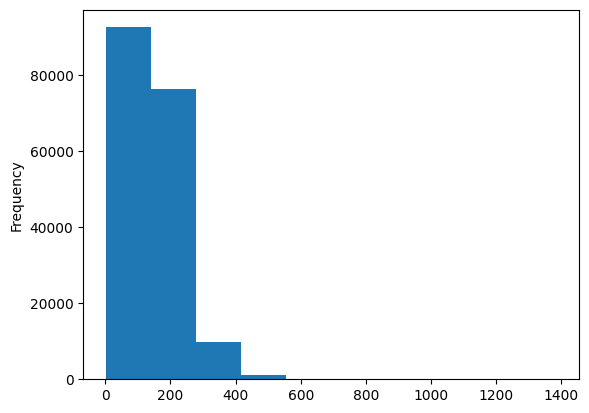

In [122]:
pd.Series(X_train).apply(len).plot.hist()

In [123]:
np.percentile(pd.Series(X_train).apply(len).to_numpy(), 95.7)

299.0

In [ ]:
character_vectorizer = TextVectorization(
    max_tokens = 28,
    split='character',
    output_sequence_length=300,
)

: 

In [ ]:
character_vectorizer.adapt(X_train_chars)

In [ ]:
vocab = character_vectorizer.get_vocabulary()

In [ ]:
vocab

['',
 '[UNK]',
 ' ',
 'e',
 't',
 'i',
 'a',
 'n',
 'o',
 'r',
 's',
 'd',
 'c',
 'l',
 'h',
 'p',
 'm',
 'u',
 'f',
 'g',
 'y',
 'w',
 'v',
 'b',
 'k',
 'x',
 'z',
 'q']

In [ ]:
character_vectorizer(X_val[0])

<tf.Tensor: shape=(300,), dtype=int64, numpy=
array([ 5, 19,  3,  2, 10,  3,  7, 10,  5,  4,  5, 26,  6,  4,  5,  8,  7,
        2,  4,  8,  2,  6, 10, 15,  3,  9, 19,  5, 13, 13, 17, 10,  2, 18,
       17, 16,  5, 19,  6,  4, 17, 10,  2,  6,  7, 11,  2,  6,  2, 15,  8,
       10,  5,  4,  5, 22,  3,  2, 10, 15, 17,  4, 17, 16,  2, 18, 17,  7,
       19,  6, 13,  2, 12, 17, 13,  4, 17,  9,  3,  2,  9,  3, 10, 17, 13,
        4,  2,  6,  9,  3,  2, 12,  8, 16, 16,  8,  7,  2,  5,  7,  2, 15,
        6,  4,  5,  3,  7,  4, 10,  2, 21,  5,  4, 14,  2,  9,  3, 18,  9,
        6, 12,  4,  8,  9, 20,  2,  6, 10,  4, 14, 16,  6,  2,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,

In [ ]:
EMBEDDING_DIMENSIONS = 128
model_3_embedding = Embedding(
    input_dim=30,
    output_dim=EMBEDDING_DIMENSIONS,
    mask_zero=True,
)

inputs = keras.layers.Input(shape=(1,), dtype=tf.string)

x = character_vectorizer(inputs)
x = model_3_embedding(x)
x = keras.layers.Conv1D(128,7, activation='relu')(x)
x = keras.layers.MaxPool1D(2)(x)
x = keras.layers.Conv1D(64,3,activation='relu')(x)
x = keras.layers.MaxPool1D(2)(x)
x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dense(NUM_CLASSES)(x)
outputs = keras.layers.Activation(keras.activations.softmax, dtype=tf.float32)(x)

model_3 = keras.Model(inputs,outputs)

model_3.compile(
    optimizer= keras.optimizers.Adam(), 
    loss = CategoricalCrossentropy(), 
    metrics=['accuracy']#, keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()]
    )

In [ ]:
keras.mixed_precision.global_policy()

<Policy "mixed_float16">

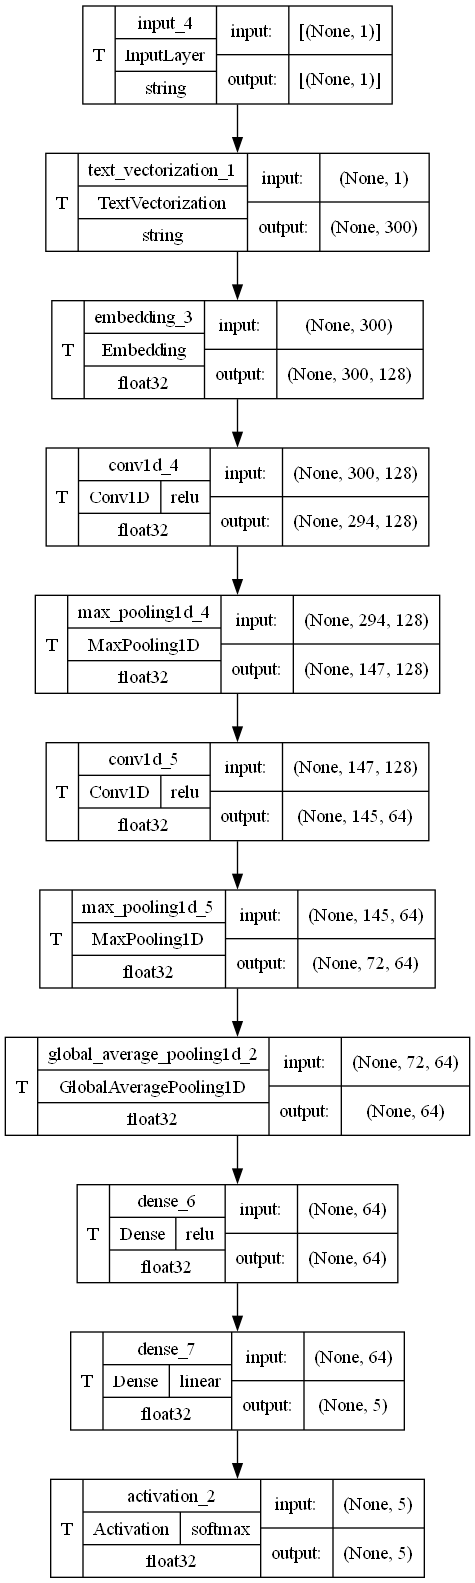

In [ ]:
plot_model(model_3)